<a href="https://colab.research.google.com/github/ricsilrib/teoria-dos-grafos-trabalho-pratico-2/blob/main/recomendacao_definitivo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install fastai --upgrade

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
from fastai.collab import *
from fastai.tabular.all import *
import pandas as pd
idx = pd.IndexSlice

## Base de dados e criação do dataloader para modelo de aprendizado de máquina

In [3]:
links = pd.read_csv("http://www.data2learning.com/repo/datasets/movielens/links.csv",  index_col=['movieId'])
movies = pd.read_csv("http://www.data2learning.com/repo/datasets/movielens/movies.csv", sep=",", index_col=['movieId'])
ratings = pd.read_csv("http://www.data2learning.com/repo/datasets/movielens/ratings.csv", index_col=['userId','movieId'])
tags = pd.read_csv("http://www.data2learning.com/repo/datasets/movielens/tags.csv", index_col=['userId','movieId'])
movies_dls = pd.read_csv("http://www.data2learning.com/repo/datasets/movielens/movies.csv", sep= ",", delimiter=",", usecols=(0,1), header= 'infer')
ratings_dls = pd.read_csv("http://www.data2learning.com/repo/datasets/movielens/ratings.csv", delimiter=',', header='infer')
ratings_merged = ratings_dls.merge(movies_dls)
dls = CollabDataLoaders.from_df(ratings_merged, item_name='title', bs=64)

In [19]:
print("Total de usuários na base: %i" % len(list(set([x[0] for x in ratings.index.values]))))
print("Total de filmes: %i" % (movies.shape[0]))
print("Total de avaliações: %i" % (ratings.shape[0]))

Total de usuários na base: 610
Total de filmes: 9742
Total de avaliações: 100836


In [20]:
ratings_merged

,userId,movieId,rating,timestamp,title
0,1,1,4.0,964982703,Toy Story (1995)
1,5,1,4.0,847434962,Toy Story (1995)
2,7,1,4.5,1106635946,Toy Story (1995)
3,15,1,2.5,1510577970,Toy Story (1995)
4,17,1,4.5,1305696483,Toy Story (1995)
...,...,...,...,...,...
100831,610,160341,2.5,1479545749,Bloodmoon (1997)
100832,610,160527,4.5,1479544998,Sympathy for the Underdog (1971)
100833,610,160836,3.0,1493844794,Hazard (2005)
100834,610,163937,3.5,1493848789,Blair Witch (2016)


## Funções sugeridas pelo professor

In [21]:
def get_movies_by_user(id_user, rating_cut=0, list_=False):
   
    return_dict = {}
    dict_ = ratings.loc[idx[id_user, :], 'rating'].T.to_dict()
    
    for d in dict_:
        if rating_cut != 0:
            if dict_[d] >= rating_cut:
                return_dict[d[1]] = dict_[d]
        else:
            return_dict[d[1]] = dict_[d]
    
    if list_:
        return list(return_dict.keys())

    return return_dict

def get_movie_title(id_movie):
    
    info = movies.loc[idx[id_movie], :]
    return info['title']


def get_all_users(ratings_):
    
    return list(set([x[0] for x in ratings_.index.values]))

In [22]:
all_users = get_all_users(ratings)

movies_user = {}

for user in all_users:
    movies_user[user] = get_movies_by_user(user, rating_cut=5, list_=True)

## Grafo com aresta ligando cada usuário (node_userId) aos filmes avaliados (node_filmId) 

In [23]:
G = nx.Graph()

options = {"node_size": 0.3, "alpha": 0.8}
for user in all_users:
  node_userId = "User" + str(user)
  node_filmId = str(movies_user[user])
  G.add_edge(node_userId,node_filmId)

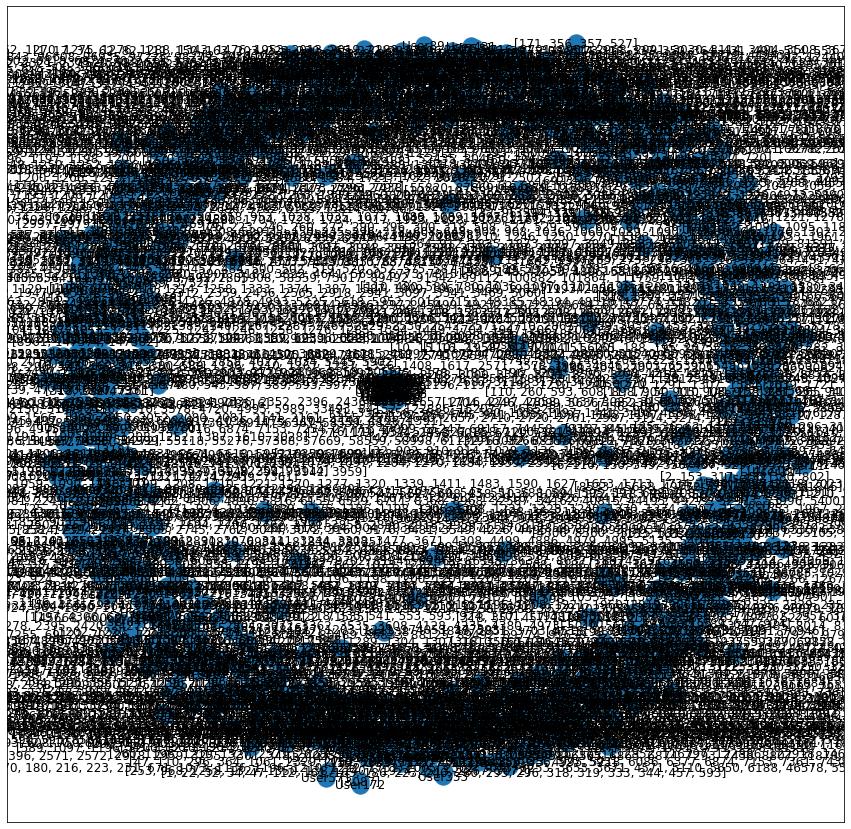

In [24]:
plt.figure(figsize=(15,15))
nx.draw_networkx(G, pos=nx.spring_layout(G), with_labels=True)
plt.show()

In [25]:
def recomendacao(user, G):

  learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))
  learn.fit_one_cycle(5, 5e-3, wd=0.1)
  learn.model
  user_factors = learn.model.u_weight.weight
  idx2 = dls.classes['userId'].o2i['user']
  distances = nn.CosineSimilarity(dim=1)(user_factors, user_factors[idx2][None])
  idx2 = distances.argsort(descending=True)[1]
  similarity = dls.classes['userId'][idx2]
  list_of_movies_recommended = []

  list_film_ids= get_movies_by_user(user, rating_cut=4, list_=True)
  for films in list_film_ids:
    list_of_movies_recommended = list_of_movies_recommended + [get_movie_title(films)]
    
  return list_of_movies_recommended

recomendacao(50,G)


epoch,train_loss,valid_loss,time
0,0.813817,0.808146,00:18
1,0.725540,0.733436,00:20
2,0.568430,0.717650,00:20
3,0.421854,0.711868,00:20
4,0.309580,0.712129,00:18


['Taxi Driver (1976)',
 'Pulp Fiction (1994)',
 'Blade Runner (1982)',
 'Fargo (1996)',
 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)',
 'Godfather, The (1972)',
 "Singin' in the Rain (1952)",
 'Vertigo (1958)',
 'Citizen Kane (1941)',
 '2001: A Space Odyssey (1968)',
 'Monty Python and the Holy Grail (1975)',
 'Brazil (1985)',
 'Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)',
 'Lawrence of Arabia (1962)',
 'Clockwork Orange, A (1971)',
 'Apocalypse Now (1979)',
 'Stalker (1979)',
 '8 1/2 (8½) (1963)',
 'Chinatown (1974)',
 'Shining, The (1980)',
 'Akira (1988)',
 'Seven Samurai (Shichinin no samurai) (1954)',
 "Rosemary's Baby (1968)",
 'Jules and Jim (Jules et Jim) (1961)',
 'Mirror, The (Zerkalo) (1975)',
 'Conversation, The (1974)',
 'Breathless (À bout de souffle) (1960)',
 'That Obscure Object of Desire (Cet obscur objet du désir) (1977)',
 'Spirited Away (Sen to Chihiro no kamikakushi) (2001)',
 'Persona (1966)',
 'Scen